In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from scipy.special import softmax

import warnings
warnings.filterwarnings('ignore')

### Importamos el dataset:

In [2]:
df = pd.read_csv('calamaro.txt', sep='/n', header=None)
df.sample(10)

,0
848,Me acompaña el mate amargo
714,Tu cicatriz
510,Es tan fácil perder la razón
568,Aunque pueda parecerte un desatino
803,El campeón tiene miedo
432,"Alrededor paranoia y dolor, la moneda cayó"
828,estoy cansado de los que vienen de amigos
391,No hay pájaros en el nido
121,Soy el soldado de tu lado malvado
871,¿Para qué guardar rencor?


### Preprocesamiento:

In [3]:
# Largo de la secuencia, incluye seq input + word output
train_len = 4

text = df.loc[1,0]
text

'No me claves tus puñales por la espalda'

In [4]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['no', 'me', 'claves', 'tus', 'puñales', 'por', 'la', 'espalda']

In [5]:
# Recorrer todas las filas y transformar las oraciones en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))
    
sentence_tokens[:3]

[['flaca'],
 ['no', 'me', 'claves', 'tus', 'puñales', 'por', 'la', 'espalda'],
 ['tan', 'profundo']]

In [6]:
# Código para hacer el desfasaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

text_sequences

[['no', 'me', 'claves', 'tus'],
 ['me', 'claves', 'tus', 'puñales'],
 ['claves', 'tus', 'puñales', 'por'],
 ['tus', 'puñales', 'por', 'la']]

### Tokenización:

In [7]:
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Ahora sequences tiene los números "ID", largo 4
sequences

[[6, 4, 2, 1], [4, 2, 1, 3], [2, 1, 3, 5], [1, 3, 5, 7]]

In [8]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

4


In [9]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

7


In [10]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'tus': 1, 'claves': 2, 'puñales': 3, 'me': 4, 'por': 5, 'no': 6, 'la': 7}


In [11]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'tus': 4, 'claves': 3, 'me': 2, 'no': 1, 'puñales': 3, 'por': 2, 'la': 1})


In [12]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                              Flaca
1            No me claves tus puñales por la espalda
2                                       Tan profundo
3                      No me duelen, no me hacen mal
4                                              Lejos
5                          En el centro de la tierra
6                                Las raíces del amor
7                            Donde estaban, quedarán
8                             Entre el no me olvides
9                 Me dejé nuestros abriles olvidados
10                           En el fondo del placard
11                           Del cuarto de invitados
12                              Eran tiempos dorados
13                                   Un pasado mejor
14    Aunque casi me equivoco y te digo poco a poco:
15             No me mientas, no me digas la verdad,
Name: 0, dtype: object

In [13]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus[:3000]

'Flaca No me claves tus puñales por la espalda Tan profundo No me duelen, no me hacen mal Lejos En el centro de la tierra Las raíces del amor Donde estaban, quedarán Entre el no me olvides Me dejé nuestros abriles olvidados En el fondo del placard Del cuarto de invitados Eran tiempos dorados Un pasado mejor Aunque casi me equivoco y te digo poco a poco: No me mientas, no me digas la verdad, No te quedes callada, no levantes la voz, Ni me pidas perdón Aunque casi te confieso Que también he sido un perro compañero Un perro ideal que aprendió a ladrar Y a volver al hogar, para poder comer Flaca No me claves, tus puñales, por la espalda Tan profundo No me duelen, no me hacen mal Lejos En el centro de la tierra Las raíces del amor Donde estaban, quedaran Cuando no estás O me encuentro en otro lugar del mundo Cuando no estás Me equivoco cada medio segundo Cuando no estás La soledad me aconseja mal Cuando no estás No se abre el paracaídas y salto igual Y me pierdo en habitaciones vacías Cuand

In [14]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['flaca',
 'no',
 'me',
 'claves',
 'tus',
 'puñales',
 'por',
 'la',
 'espalda',
 'tan',
 'profundo',
 'no',
 'me',
 'duelen',
 'no',
 'me',
 'hacen',
 'mal',
 'lejos',
 'en']

In [15]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 6058


In [16]:
# Código para hacer el desfasaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
    
text_sequences[:20]

[['flaca', 'no', 'me', 'claves'],
 ['no', 'me', 'claves', 'tus'],
 ['me', 'claves', 'tus', 'puñales'],
 ['claves', 'tus', 'puñales', 'por'],
 ['tus', 'puñales', 'por', 'la'],
 ['puñales', 'por', 'la', 'espalda'],
 ['por', 'la', 'espalda', 'tan'],
 ['la', 'espalda', 'tan', 'profundo'],
 ['espalda', 'tan', 'profundo', 'no'],
 ['tan', 'profundo', 'no', 'me'],
 ['profundo', 'no', 'me', 'duelen'],
 ['no', 'me', 'duelen', 'no'],
 ['me', 'duelen', 'no', 'me'],
 ['duelen', 'no', 'me', 'hacen'],
 ['no', 'me', 'hacen', 'mal'],
 ['me', 'hacen', 'mal', 'lejos'],
 ['hacen', 'mal', 'lejos', 'en'],
 ['mal', 'lejos', 'en', 'el'],
 ['lejos', 'en', 'el', 'centro'],
 ['en', 'el', 'centro', 'de']]

In [17]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[613, 1, 9, 356],
 [1, 9, 356, 117],
 [9, 356, 117, 357],
 [356, 117, 357, 14],
 [117, 357, 14, 5],
 [357, 14, 5, 358],
 [14, 5, 358, 52],
 [5, 358, 52, 202],
 [358, 52, 202, 1],
 [52, 202, 1, 9],
 [202, 1, 9, 359],
 [1, 9, 359, 1],
 [9, 359, 1, 9],
 [359, 1, 9, 360],
 [1, 9, 360, 80],
 [9, 360, 80, 162],
 [360, 80, 162, 11],
 [80, 162, 11, 2],
 [162, 11, 2, 361],
 [11, 2, 361, 3]]

In [18]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 6054


In [19]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [20]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [21]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [22]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(6054, 3)
(6054,)


In [23]:
# Palabras del vocabulario
resultado = {k: tok.index_word[k] for k in list(tok.index_word)[:20]}
resultado

{1: 'no',
 2: 'el',
 3: 'de',
 4: 'que',
 5: 'la',
 6: 'y',
 7: 'a',
 8: 'te',
 9: 'me',
 10: 'se',
 11: 'en',
 12: 'un',
 13: 'es',
 14: 'por',
 15: 'amor',
 16: 'del',
 17: 'puede',
 18: 'mi',
 19: 'quiero',
 20: 'porque'}

In [24]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1198

In [25]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(6054, 1198)

In [26]:
# Largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [27]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1198

### Definición y entrenamiento del modelo:

In [28]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=25, input_length=input_seq_len))

# Primera capa LSTM con 128 unidades
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))

# Segunda capa LSTM con 128 unidades
model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Dropout(0.3))

# Tercera capa LSTM con 64 unidades
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Cuarta capa LSTM con 64 unidades
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

# Quinta capa LSTM con 64 unidades
model.add(Bidirectional(LSTM(64)))
#model.add(Dropout(0.5))

# Capas densas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Capa de salida
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 25)             29975     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           157696    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 256)           394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 128)           164352    
 nal)                                                            
                                                        

In [29]:
early_stop = EarlyStopping(
    monitor='accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
152/152 [==============================] - 14s 27ms/step - loss: 6.2384 - accuracy: 0.0285 - val_loss: 6.6201 - val_accuracy: 0.0372
Epoch 2/100
152/152 [==============================] - 2s 14ms/step - loss: 5.5882 - accuracy: 0.0378 - val_loss: 6.9942 - val_accuracy: 0.0264
Epoch 3/100
152/152 [==============================] - 2s 13ms/step - loss: 5.4328 - accuracy: 0.0384 - val_loss: 7.2988 - val_accuracy: 0.0264
Epoch 4/100
152/152 [==============================] - 2s 13ms/step - loss: 5.3159 - accuracy: 0.0337 - val_loss: 7.4249 - val_accuracy: 0.0264
Epoch 5/100
152/152 [==============================] - 2s 13ms/step - loss: 5.2118 - accuracy: 0.0370 - val_loss: 7.8796 - val_accuracy: 0.0215
Epoch 6/100
152/152 [==============================] - 2s 13ms/step - loss: 5.1272 - accuracy: 0.0287 - val_loss: 8.3951 - val_accuracy: 0.0355
Epoch 7/100
152/152 [==============================] - 2s 12ms/step - loss: 5.0668 - accuracy: 0.0365 - val_loss: 8.5043 - val_accuracy

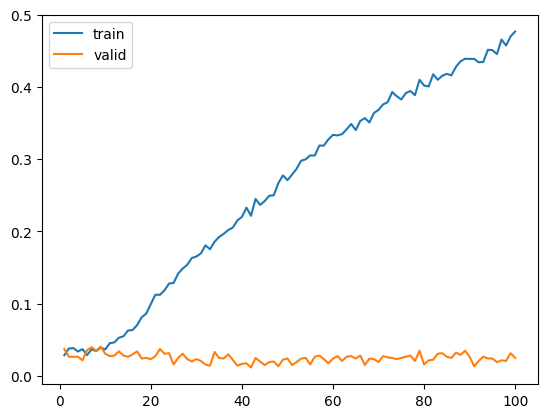

In [30]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [31]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 14ms/step
Keyboard interruption in main thread... closing server.


In [38]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
        # Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

        # Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [67]:
input_text='No se puede vivir'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 13ms/step


'No se puede vivir amor'

In [52]:
input_text='yo soy un'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 14ms/step


'yo soy un loco que'

In [63]:
# Funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):
    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [123]:
# Función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=2):

    # colectar todas las probabilidades para la siguiente búsqueda
    pred_large = []

    for idx,pp in enumerate(pred):
        pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

    # traducir a índices de token en el vocabulario
    new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

    # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens) 

    # beam search loop
    for i in range(num_words-1):

        preds = []

        for hist in history_tokens:

        # actualizar secuencia de tokens
            input_update = np.array([hist[i+1:]]).copy()

        # predicción
            y_hat = np.squeeze(model.predict(input_update)) 

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens) 

    return history_tokens

In [135]:
# Predicción con beam search
salidas = beam_search(model,num_beams=10, num_words=4, input="quiero ser el")
decode(salidas[0])

1/1 [==============================] - 0s 14ms/step


['quiero ser el único que dijo vientos']

### Conclusiones:

Se logró desarrollar un predictor de palabra siguiente, y así formar una secuencia más larga de palabras. Sin embargo, este no tiene tanta precisión, sobre todo en la validación.

Si bien es cierto, los resultados no fueron los mejores, aún así se pudo demostrar la funcionalidad del modelo.
Por ejemplo, usando la función 'generate_seq' con la secuencia 'No se puede vivir', se obtuvo una salida ''No se puede vivir amor', lo cual sí tiene bastante sentido, ya que la letra de la canción dice 'No se puede vivir del amor'. Así que si bien es cierto, no se obtuvo ser fiel al 100% a la letra, sí se consiguió que la palabra predicha sí guarde relación con la letra de la canción.

Luego cuando se quiso predecir 2 palabras, se usó la entrada 'yo soy un', se obtuvo como salida 'yo soy un loco que', lo cual es tal cual la letra original de la canción la cual es 'yo soy un loco que se dio cuenta'

Por último, al hacer la predicción con la función 'beam_search', se predijeron las 3 palabra siguientes. Se usó como input 'quiero ser el' y se esperaba obtener algo parecido a la letra 'quiero ser el único que te muerda la boca'. Y si bien es cierto no se obtuvo tal cual esa letra, sí se consiguieron las 2 palabras siguientes 'único que', pero luego se obtuvieron palabras que no guardaban relación con la letra de la canción.